# Thermal Radiation Tracking with Integral Loss  (Right Level Order)

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.nn import *
from torchdyn.datasets import *
from torchdyn.utils import *

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2

Extension horovod.torch has not been built: /home/user/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [2]:
import numpy as np
from tqdm import tqdm
files = !ls data
XYdata = {}
for file in files:
    XYdata[file.split('.')[0]] = np.load('data/'+file) 
    print(XYdata[file.split('.')[0]].shape, file)

(135680, 137) ccl4_vmr.npy
(135680, 137) cfc11_vmr.npy
(135680, 137) cfc12_vmr.npy
(135680, 137) ch4_vmr.npy
(135680, 137) cloud_fraction.npy
(135680, 137) co2_vmr.npy
(135680,) cos_solar_zenith_angle.npy
(135680, 138) flux_dn_lw.npy
(135680, 138) flux_dn_sw.npy
(135680, 138) flux_up_lw.npy
(135680, 138) flux_up_sw.npy
(135680, 137) fractional_std.npy
(135680, 137) hcfc22_vmr.npy
(135680, 137) hr_lw.npy
(135680, 137) hr_sw.npy
(135680, 137) inv_cloud_effective_size.npy
(135680,) lat.npy
(135680,) lon.npy
(135680, 2) lw_emissivity.npy
(135680, 137) n2o_vmr.npy
(135680, 137) o2_vmr.npy
(135680, 137) o3_mmr.npy
(135680, 136) overlap_param.npy
(135680, 138) pressure_hl.npy
(135680, 137) q.npy
(135680, 137) q_ice.npy
(135680, 137) q_liquid.npy
(135680, 137) re_ice.npy
(135680, 137) re_liquid.npy
(135680,) skin_temperature.npy
(135680,) solar_irradiance.npy
(135680, 6) sw_albedo.npy
(135680, 6) sw_albedo_direct.npy
(135680, 138) temperature_hl.npy


In [3]:
not_cloudy_ids = [i for i in range(135680) if max(XYdata['cloud_fraction'][i]) < 0.001]
len(not_cloudy_ids)

5833

In [4]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(not_cloudy_ids, test_size=0.02, random_state=108)
len(train_ids), len(test_ids)

(5716, 117)

In [5]:
h_max = 138

In [ ]:
def prepareX(i):
    return list(zip([(XYdata['flux_up_lw'][i][-l] + XYdata['flux_up_lw'][i][-l-1]) / 2. for l in range(h_max-1)],
               [XYdata['skin_temperature'][i]]*(h_max-1),
               XYdata['o3_mmr'][i],
               XYdata['cloud_fraction'][i],
               XYdata['re_ice'][i],                   
               XYdata['re_liquid'][i],
               XYdata['q_ice'][i],
               XYdata['q_liquid'][i],
               [(XYdata['temperature_hl'][i][-l] + XYdata['temperature_hl'][i][-l-1]) / 2. for l in range(h_max-1)]  
              ))

In [97]:
X = torch.tensor([prepareX(i) for i in train_ids]).float()

In [98]:
X.shape

torch.Size([5716, 137, 9])

<Figure size 576x216 with 0 Axes>

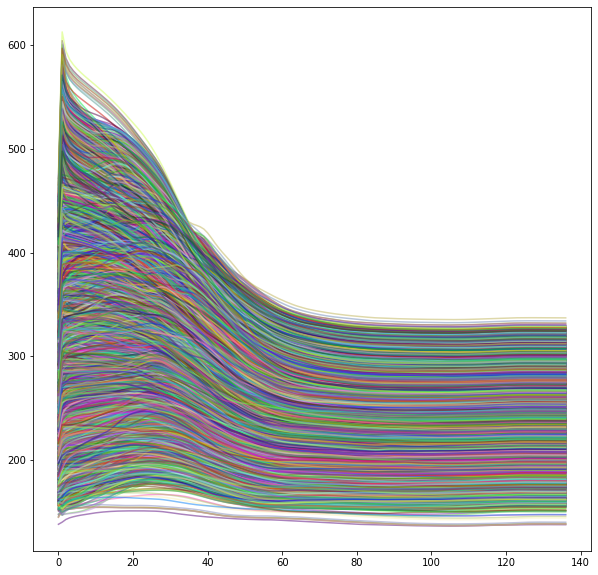

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.figure(figsize=(8,3))
colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for x in X:
    c=np.random.rand(3,)
    ax.plot(range(h_max-1), x[:,0], color=c, alpha=.5)

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)

In [101]:
def getY(t):
    return X[int(t)][0]

In [102]:
t_span = torch.linspace(0, h_max-2,h_max-1).to(device)
t_span

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136.], device='cuda:0')

## Integral Loss

We consider a loss of type

$$
    \ell_\theta := \int_0^S g(z(t))d\tau
$$

where $z(s)$ satisfies the neural ODE initial value problem 

$$
    \left\{
    \begin{aligned}
        \dot{z}(t) &= f(z(t), \theta(t))\\
        z(0) &= x
    \end{aligned}
    \right. \quad t\in[0,T]
$$

where $\theta(t)$ is parametrized with some spectral method (`Galerkin-style`),  i.e. $\theta(t)=\theta(t,\omega)$ [$\omega$: parameters of $\theta(t)$].

**REMARK:** In `torchdyn`, we do not need to evaluate the following integral in the forward pass of the ODE integration.
In fact, we will compute the gradient $d\ell/d\omega$ just by solving backward 

$$
    \begin{aligned}
        \dot\lambda (t) &= -\frac{\partial f}{\partial z}\lambda(t) + \frac{\partial g}{\partial z} \\
        \dot\mu (t) &= -\frac{\partial f}{\partial \theta}\frac{\partial \theta}{\partial \omega}\lambda(t)
    \end{aligned}~~\text{with}~~
    \begin{aligned}
        \lambda (T) &= 0\\
        \mu (T) &= 0
    \end{aligned}
$$

and, $\frac{d\ell}{d\omega} = \mu(0)$. Check out [this paper](https://arxiv.org/abs/2003.08063) for more details on the integral adjoint for Neural ODEs.

**Example:** Use a neural ODE to track a 2D curve $\gamma:[0,\infty]\rightarrow \mathbb{S}_2$ ($\mathbb{S}_2$: unit circle, $\mathbb{S}_2:=\{x\in\mathbb{R}^2:||x||_2=1\}$), i.e.

$$
    \gamma(s) := [\cos(2\pi s), \sin(2\pi s)]
$$

which has periodicity equal to $1$: $\forall n\in\mathbb{N}, \forall s\in[0,\infty]~~\gamma(s) = \gamma(ns)$.

Let suppose to train the neural ODE for $s\in[0,1]$. Therefore we can easily setup the integral cost as

$$
    \ell_\theta := \int_0^1 (h(\tau)-\gamma(\tau))^2 d\tau
$$

In [103]:
# simple Callables are also fine as integral losses, as long as they're callable with `t, x`. We use nn.Modules for convenience, since
# we compute the reference signal here as well
class InterpolationIntegralLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def y(self, t):
        y = X[:,int(t),0]    
        return y
#         return y.to(t)
        
    def forward(self, t, x):
        loss = nn.MSELoss(reduction='none')
        int_loss = torch.mean(loss(self.y(t), x[:,0] ),dim=0)
        return int_loss

In [85]:
# dummy trainloader
train = torch.utils.data.TensorDataset(torch.zeros(1), torch.zeros(1))
trainloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)

**Learner**

In [104]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iterations = 0
        
    def forward(self, x):
        return self.model(x)    
    
    def training_step(self, batch, batch_idx):    
        self.iterations += 1
        # We sample from Normal distribution around "nominal" initial condition
        x = X[:,0,:]
        _, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1]
        
        # We need to evaluate a "dummy loss" (just the summed output of the model)
        # to construct the graph for the 'backward()' "triggering" integral adjoint computation 
        loss = 0. * y_hat.sum()
        intloss = None
        
        if (self.iterations % 10 == 0) or(dry_run and self.iterations %2 == 0):
            
            with torch.no_grad():
            # compute integral loss explicitly by augmentation of state with 
            # an aux. variable. See `Dissecting Neural ODEs` for more information
#                 model.sensitivity = model.vf.sensitivity = 'autograd' 
                model.sensitivity = model.vf.sensitivity = 'adjoint' 
                x = X[:,-1,:]
                _, sol = self.model(x, t_span)
                intloss = sol.mean()
#                 model.sensitivity = model.vf.sensitivity = 'interpolated_adjoint'
                model.sensitivity = model.vf.sensitivity = 'adjoint'

            self.log('intloss', intloss, prog_bar=True)

        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-3)

    def train_dataloader(self):
        return trainloader

## Parameter Varying Neural ODE

**Model**

In [105]:
# We use a Galerkin Neural ODE with one hidden layer, 
# Fourier spectrum (period=1) and only 2 freq.s
f = nn.Sequential(nn.Linear(X.shape[2], 64),
                  nn.Tanh(),
                  nn.Linear(64, X.shape[2])).to(device)
# f = nn.Sequential(nn.Linear(1, 64),
#                   nn.Tanh(),
#                   nn.Linear(64, 64),
#                   nn.Tanh(),
#                   nn.Linear(64, 1)).to(device)


# Define the model
model = NeuralODE(f, 
                 solver='rk4',
#                   solver='euler',                
#                  sensitivity='interpolated_adjoint',
                 sensitivity='adjoint',
                 solver_adjoint='dopri5',
                 atol_adjoint=1e-3,
                 rtol_adjoint=1e-3,
#                  atol_adjoint=1e-5,
#                  rtol_adjoint=1e-5,
                 integral_loss=InterpolationIntegralLoss()).to(device)                  

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [106]:
# Train the model (will take a while)
dry_run = False
learn = Learner(model)
if dry_run: trainer = pl.Trainer(max_epochs=10, log_every_n_steps=1, num_workers=96)
else: trainer = pl.Trainer(max_epochs=5000,  log_every_n_steps=50, accelerator='gpu', devices=1)
trainer.fit(learn)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 1.2 K 
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1613: PossibleUserWarning: The number of trainin

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


# 5000 Iterations

In [107]:
test_num = 10
x_test = torch.stack([torch.tensor(prepareX(i))[0] for i in test_ids[:test_num]]).float().to(device)

In [108]:
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()

Text(0.5, 1.0, 'Epochs=5000')

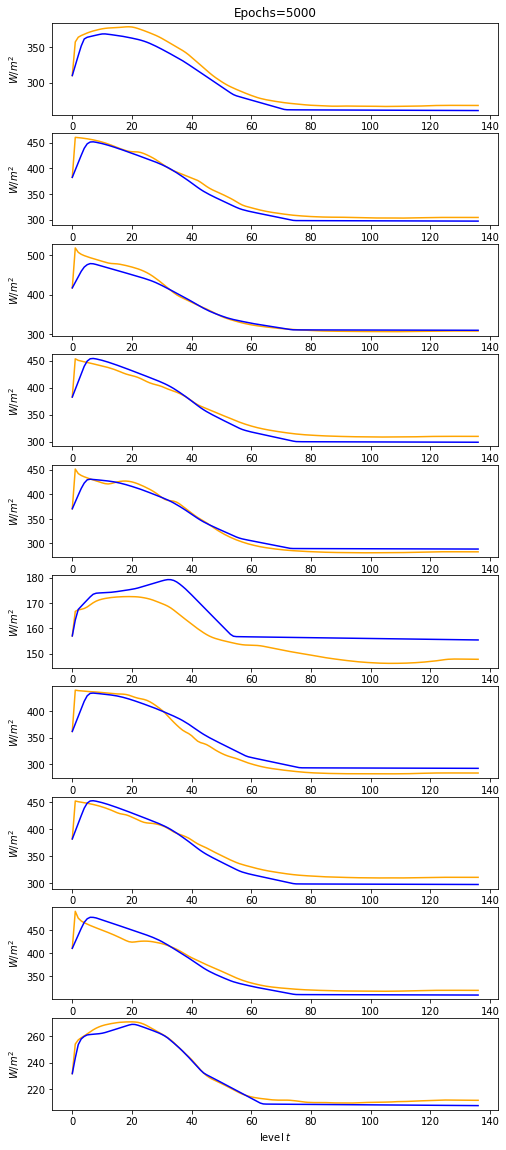

In [110]:
fig, axs = plt.subplots(test_num, sharex=False)
# fig.suptitle('Epochs=5000')
fig.set_size_inches(8, 20)
for i in range(test_num):
    axs[i].plot(t_span.cpu(), torch.tensor(prepareX(test_ids[i]))[:,0], color='orange', alpha=1.)
    axs[i].plot(t_span.cpu(), trajectory[:,i,0], color='blue', alpha=1.)
    axs[i].set_ylabel(r"$ W/m^2$")
axs[-1].set_xlabel(r"level $t$ ")
axs[0].set_title('Epochs=5000')

# 2500 Iterations

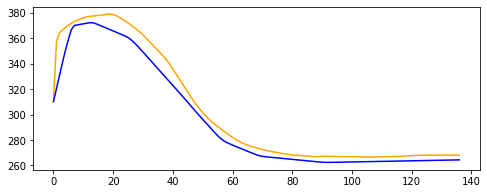

In [89]:
test_num = 0
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

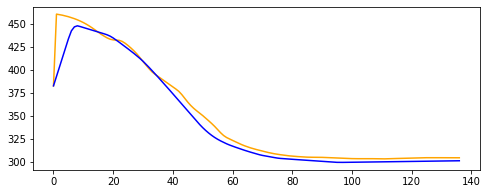

In [90]:
test_num = 1
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

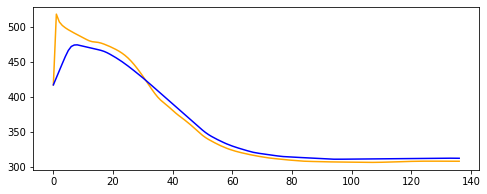

In [91]:
test_num = 2
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

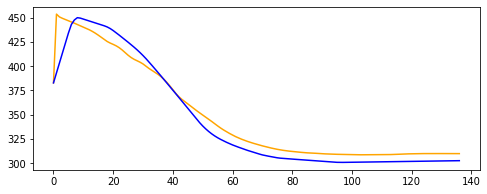

In [92]:
test_num = 3
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

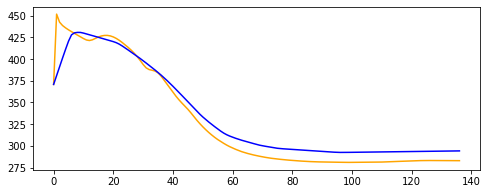

In [93]:
test_num = 4
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

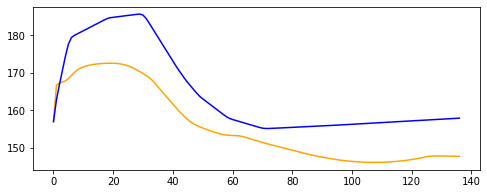

In [94]:
test_num = 5
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

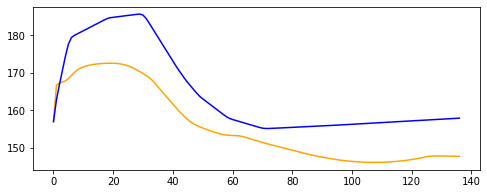

In [95]:
test_num = 5
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

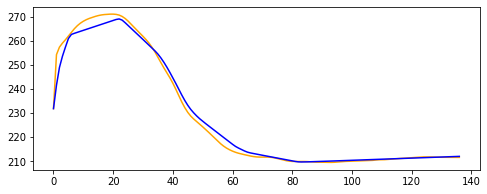

In [96]:
test_num = 9
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

**Plots**

We first evaluate the model on a test set of initial conditions sampled from $\mathcal{N}(\gamma(0),\sigma\mathbb{I})$. Since we trained the neural ODE with $\sigma=0.1$, now we test it with $\sigma=0.2$.

# 100 Iterations

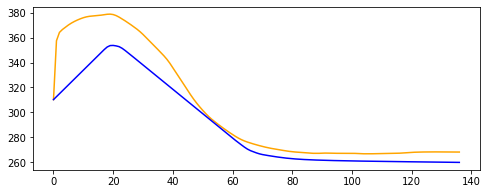

In [72]:
test_num = 0
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

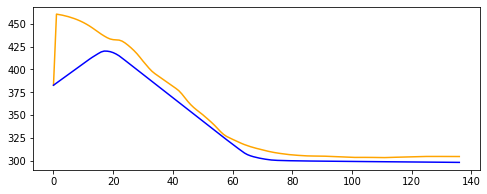

In [73]:
test_num = 1
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

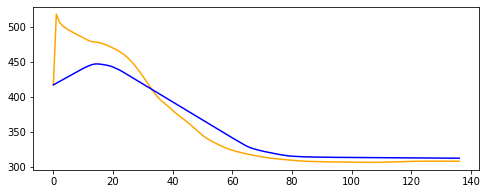

In [74]:
test_num = 2
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

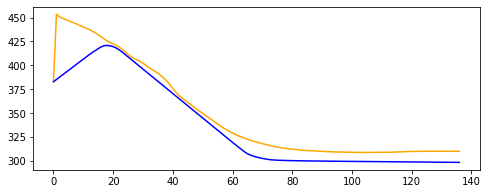

In [75]:
test_num = 3
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

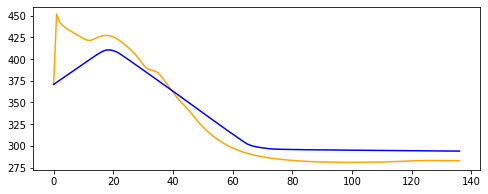

In [76]:
test_num = 4
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

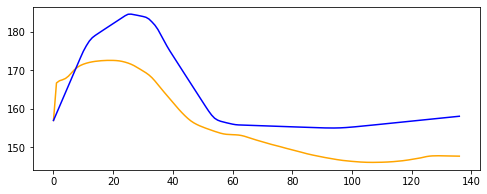

In [78]:
test_num = 5
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

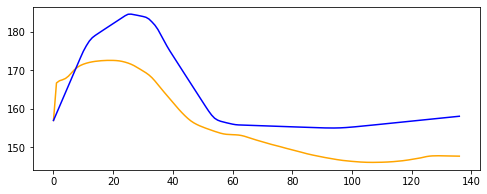

In [78]:
test_num = 5
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)

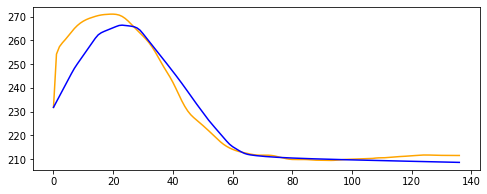

In [79]:
test_num = 9
x_test = torch.stack([torch.tensor(prepareX(test_ids[test_num]))[0]]).float().to(device)
model = model.to(device)
trajectory = model.trajectory(x_test, t_span)
trajectory = trajectory.detach().cpu()
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(t_span.cpu(), torch.tensor(prepareX(test_ids[test_num])).cpu()[:,0], color='orange', alpha=1.)
ax.plot(t_span.cpu(), trajectory[:,0,0], color='blue', alpha=1.)